In [1]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
X_train = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
y_train = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [4]:
X_train.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

There should be 26,707 entries for each column. However, most columns are missing some information and a few columns are missing a significant amount of information. Will inspect those columns and determine if they should be kept or dropped outright.

In [5]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   h1n1_vaccine      26707 non-null  int64
 1   seasonal_vaccine  26707 non-null  int64
dtypes: int64(2)
memory usage: 625.9 KB


In [6]:
y_train.h1n1_vaccine.value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [7]:
y_train.seasonal_vaccine.value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

There is a significant class imbalance for the H1N1 vaccine and I will have to use SMOTE to fix that later on when building my pipelines to account for this. For seasonal flu vaccines, the classes are more balanced and there is nothing that should be done. There are no missing values in either column.

# EDA

For the columns hhs_geo_region, employment_industry, and employment_occupation the values are represented in a short random string to protect information about the individual. The random character strings are representative of an actual region, industry, and occupation respectively. 

In [8]:
y_train_h1n1 = y_train[['h1n1_vaccine']]
y_train_flu = y_train[['seasonal_vaccine']]

In [9]:
X_train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [10]:
df = X_train.merge(y_train, on = 'respondent_id')

In [11]:
df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


## Looking at individual attitudes towards the H1N1 virus and the H1N1 vaccine

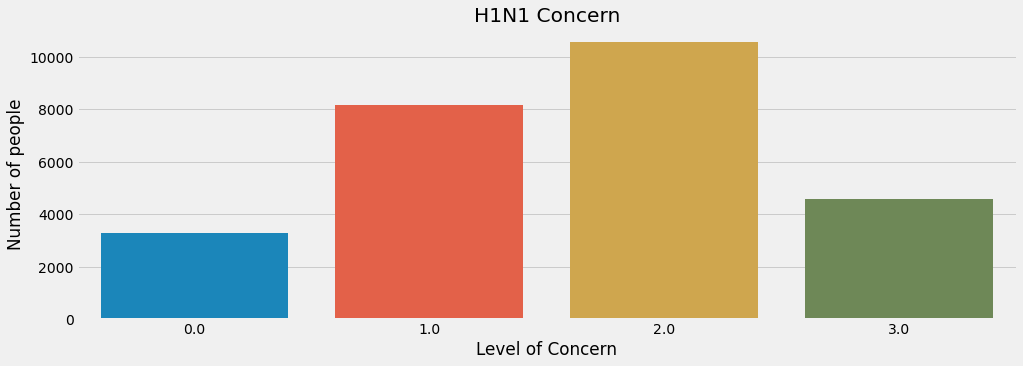

In [12]:
fig, ax = plt.subplots(figsize = (15,5))

sns.countplot(df.h1n1_concern)
plt.title('H1N1 Concern')
plt.ylabel('Number of people')
plt.xlabel('Level of Concern');

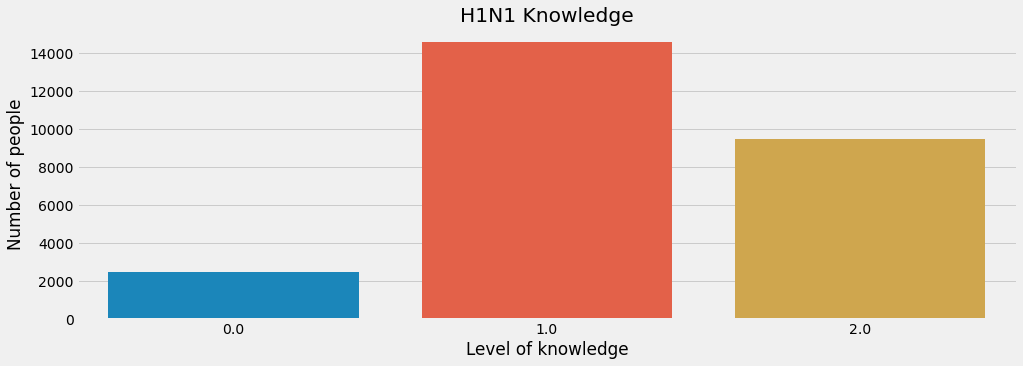

In [13]:
fig, ax = plt.subplots(figsize = (15,5))

sns.countplot(df.h1n1_knowledge)
plt.title('H1N1 Knowledge')
plt.ylabel('Number of people')
plt.xlabel('Level of knowledge');

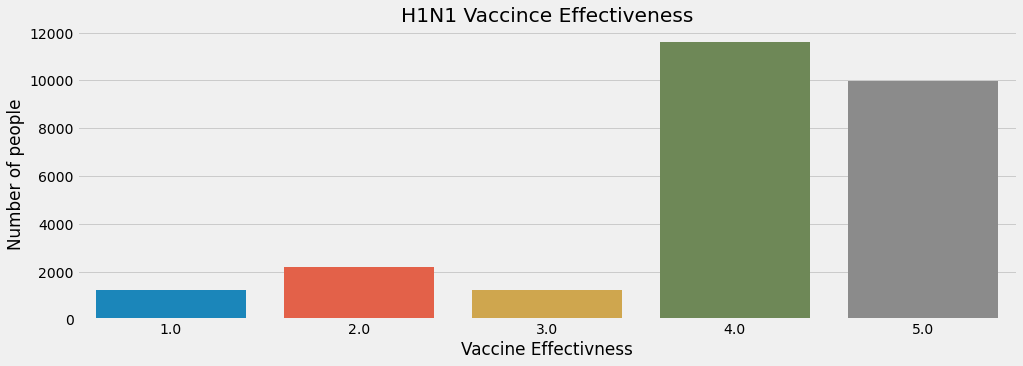

In [14]:
fig, ax = plt.subplots(figsize = (15,5))

sns.countplot(df.opinion_seas_vacc_effective)
plt.title('H1N1 Vaccince Effectiveness')
plt.ylabel('Number of people')
plt.xlabel('Vaccine Effectivness');

## Looking at H1N1 Concern by Race

In [15]:
df.race.value_counts()

White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64

In [16]:
white = df[df.race == 'White']
white_concern = white.h1n1_concern

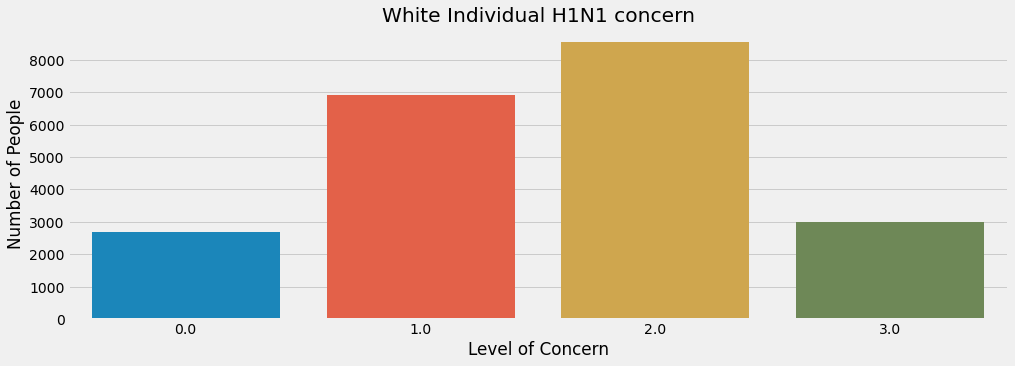

In [17]:
fig, ax = plt.subplots(figsize = (15,5))

sns.countplot(white_concern)
plt.title('White Individual H1N1 concern')
plt.ylabel('Number of People')
plt.xlabel('Level of Concern');

In [18]:
black = df[df.race == 'Black']
black_concern = black.h1n1_concern

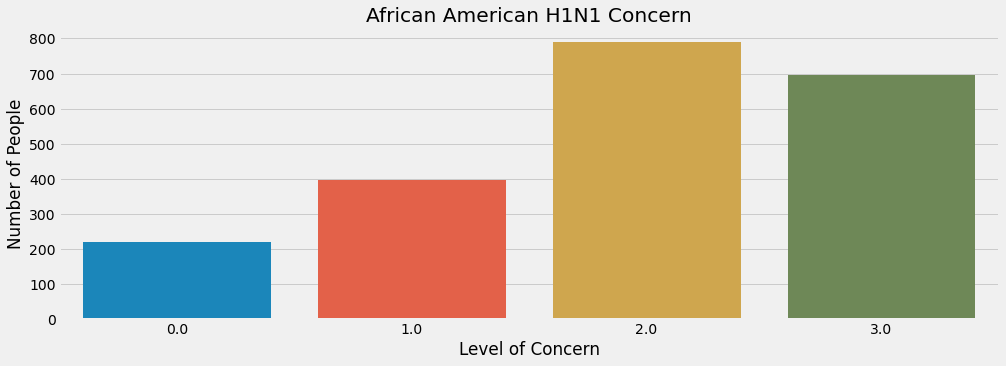

In [19]:
fig, ax = plt.subplots(figsize = (15,5))

sns.countplot(black_concern)
plt.title('African American H1N1 Concern')
plt.ylabel('Number of People')
plt.xlabel('Level of Concern');

In [20]:
hispanic = df[df.race == 'Hispanic']
hispanic_concern = hispanic.h1n1_concern

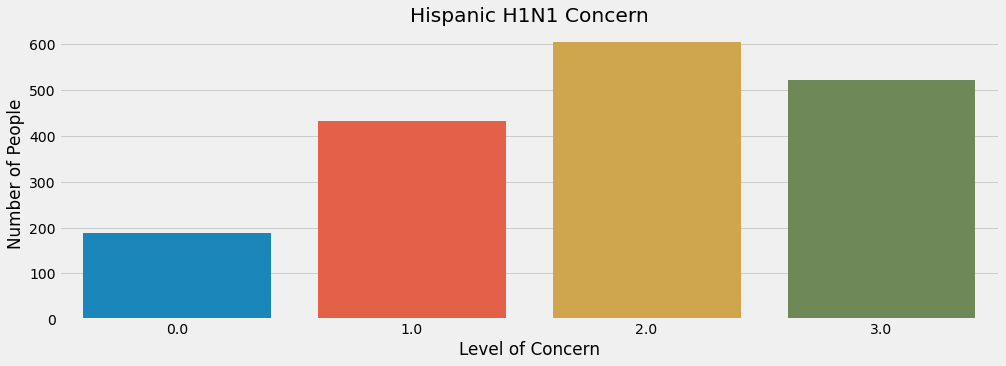

In [21]:
fig, ax = plt.subplots(figsize = (15,5))

sns.countplot(hispanic_concern)
plt.title('Hispanic H1N1 Concern')
plt.ylabel('Number of People')
plt.xlabel('Level of Concern');

In [22]:
other_multiple = df[df.race == 'Other or Multiple']
other_multiple_concern = other_multiple.h1n1_concern

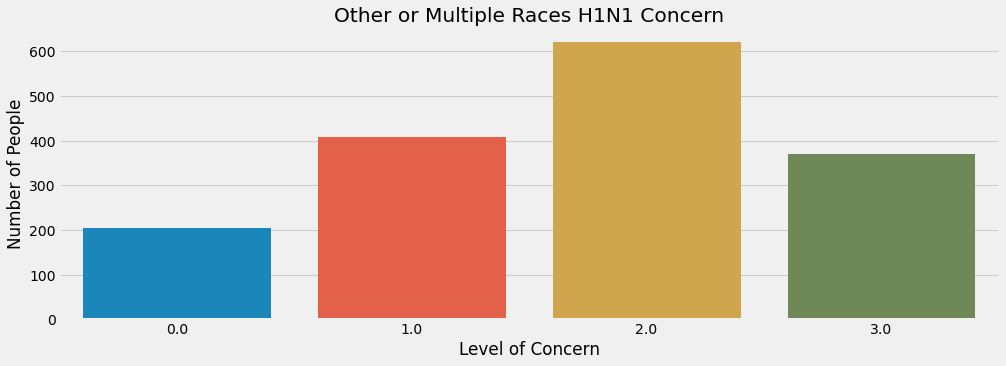

In [23]:
fig, ax = plt.subplots(figsize = (15,5))

sns.countplot(other_multiple_concern)
plt.title('Other or Multiple Races H1N1 Concern')
plt.ylabel('Number of People')
plt.xlabel('Level of Concern');